In [1]:
import os
import tensorflow as tf
from absl import app
from absl import flags
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.platform import resource_loader

2024-05-02 10:56:27.595569: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-02 10:56:27.875385: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-02 10:56:28.836146: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 10:56:30.541466: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import tflite_runtime.interpreter as tflite

ModuleNotFoundError: No module named 'tflite_runtime'

In [ ]:
interpreter = tflite.Interpreter(model_path="models/hello_world_int8.tflite")
interpreter.allocate_tensors()

In [ ]:
# Generate a list of 1000 random floats in the range of 0 to 2*pi.
def generate_random_float_input(sample_count=1000):
  # Generate a uniformly distributed set of random numbers in the range from
  # 0 to 2π, which covers a complete sine wave oscillation
  np.random.seed(42)
  x_values = np.random.uniform(low=0, high=2 * np.pi,
                               size=sample_count).astype(np.float32)
  return x_values



In [5]:
x_values = generate_random_float_input()
# Calculate the corresponding sine values
y_true_values = np.sin(x_values)

Text(0.5, 1.0, 'random angle values 0 .. 2pi')

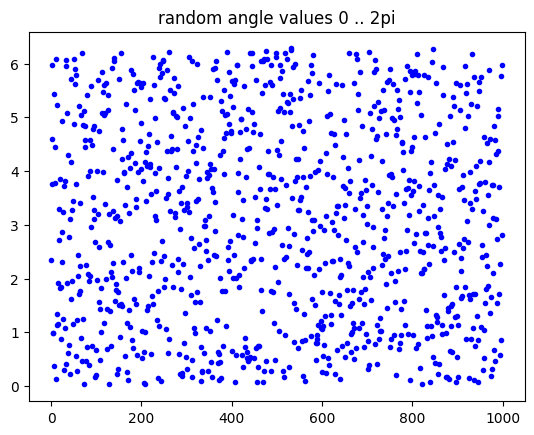

In [6]:
plt.plot(x_values,'b.')
plt.title("random angle values 0 .. 2pi")

In [7]:
print("y_values")
print(x_values[:10])
print("y_values")
print(y_true_values[:10])

y_values
[2.3533049  5.973514   4.5992537  3.7614822  0.98029405 0.9801425
 0.3649501  5.442345   3.776917   4.4489512 ]
y_values
[ 0.7091471  -0.30474553 -0.99360704 -0.58094525  0.8306611   0.8305767
  0.35690266 -0.7452037  -0.59343857 -0.9655005 ]


Text(0, 0.5, 'sine')

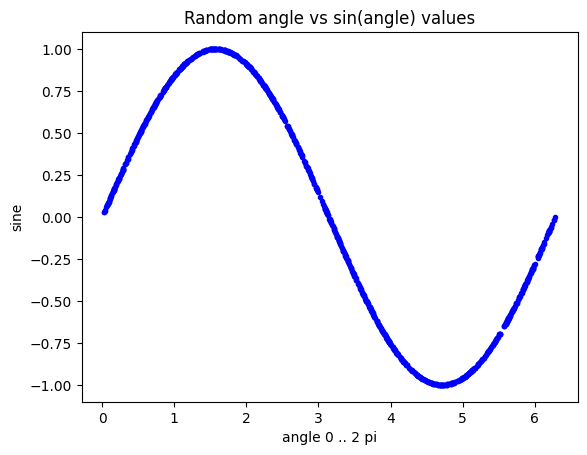

In [8]:
plt.plot(x_values,y_true_values,'b.')
plt.title("Random angle vs sin(angle) values")
plt.xlabel("angle 0 .. 2 pi")
plt.ylabel("sine")

In [ ]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
print(input_details)

In [ ]:
print(input_details[0]["quantization_parameters"])

In [ ]:
input_shape = input_details[0]["shape"]
print("input_shape: ",input_shape)
input_data = np.reshape(x_values[0],input_shape)
print("input data: ",input_data)

In [ ]:
# Load TFLite model and allocate tensors.
with open('models/hello_world_int8.tflite', 'rb') as fid:
    tflite_model = fid.read()

In [ ]:
interpreter = tf.lite.Interpreter(model_path="models/hello_world_int8.tflite")
interpreter.allocate_tensors()                                 

In [ ]:
print(interpreter.get_input_details())

In [ ]:
input_index = 0
output_index = 0
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

In [ ]:
interpreter.set_tensor(input_details[0]['index'], input_data)

In [ ]:
interpreter.invoke()

In [ ]:
tflite_output = interpreter.get_tensor(output_index)

In [ ]:
y_predictions = np.empty(x_values.size, dtype=np.float32)

In [ ]:
def invoke_tflm_interpreter(input_shape, interpreter, x_value, input_index,
                            output_index):
  input_data = np.reshape(x_value, input_shape)
  # print("input data: ",input_data)
  interpreter.set_tensor(input_index, input_data)
  interpreter.invoke()
  y_quantized = np.reshape(interpreter.get_tensor(output_details[0]["index"]), -1)[0]
  return y_quantized

In [ ]:
# Invoke the tflm interpreter with x_values in the range of [0, 2*PI] and
# returns the prediction of the interpreter.
def get_tflm_prediction(model_path, x_values):
  # Create the tflm interpreter
  tflm_interpreter = tflite.Interpreter(model_path)
  tflm_interpreter.allocate_tensors()
    
  input_details = tflm_interpreter.get_input_details()
  input_shape = np.array(input_details[0]['shape'])
  # print("input shape: ",input_shape)
  y_predictions = np.empty(x_values.size, dtype=np.float32)

  for i, x_value in enumerate(x_values):
    y_predictions[i] = invoke_tflm_interpreter(input_shape,
                                               tflm_interpreter,
                                               x_value,
                                               input_index=0,
                                               output_index=0)
  return y_predictions


In [ ]:
model_path = "models/hello_world_int8.tflite"

In [ ]:
y_predictions = get_tflm_prediction(model_path, x_values)

In [ ]:
plt.plot(x_values)

In [ ]:
plt.plot(x_values,y_true_values,'b.')

In [ ]:
plt.plot(x_values, y_predictions, 'b.', label='TFLM Prediction')